# ENV

In [ ]:
%%capture
!pip install lightning

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from einops.layers.torch import Rearrange, Reduce
from einops import reduce, rearrange, repeat, einsum, parse_shape, pack, unpack

In [ ]:
import lightning as L

In [ ]:
import seaborn as sns
sns.set()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['lines.linewidth'] = 2.0

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [ ]:
seed=42
if torch.cuda.is_available():
    device='cuda'

    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
else:
    device='cpu'

# pl.seed_everything(42) # repace all set seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device

'cuda'

# Data

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('.', download=True, transform=transform)
dataloader=DataLoader(dataset,batch_size=32,shuffle=True, drop_last=True)

batch=next(iter(dataloader))
print(len(batch))
print(batch[0].shape)
print(batch[1].shape)

2
torch.Size([32, 1, 28, 28])
torch.Size([32])


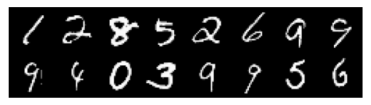

In [ ]:
from torchvision.utils import make_grid
def show_image(images, num_images=16, size=(1,28,28)):
    images=images.detach().cpu()
    grid_image=make_grid(images[:num_images], nrow=8)
    plt.imshow(grid_image.permute(1,2,0))
    plt.axis('off')
    plt.show()

show_image(batch[0])

# Architecture

In [ ]:
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2):
        super().__init__()
        self.layer=nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
                                nn.BatchNorm2d(out_channels),
                                nn.SiLU(inplace=True))

    def forward(self,x):
        return self.layer(x)

class Generator(nn.Module):
    def __init__(self, z_dim, image_channel, hidden_dim):
        super().__init__()
        self.gen=nn.Sequential(Rearrange('b c -> b c 1 1'),
                               GenBlock(z_dim, hidden_dim*4),
                               GenBlock(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
                               GenBlock(hidden_dim*2, hidden_dim),
                               nn.ConvTranspose2d(hidden_dim,image_channel, kernel_size=4, stride=2),
                               nn.Tanh())

    def forward(self,x):
        return self.gen(x)

x=torch.rand([7,13])
tmp=Generator(13,1,14)
tmp(x).shape

torch.Size([7, 1, 28, 28])

In [ ]:
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2):
        super().__init__()
        self.layer=nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride)),
                                 nn.BatchNorm2d(out_channels),
                                 nn.SiLU(inplace=True))
    def forward(self,x):
        return self.layer(x)

class Discriminator(nn.Module):
    def __init__(self, image_channel, hidden_dim):
        super().__init__()
        self.disc=nn.Sequential(DiscBlock(image_channel, hidden_dim),
                                DiscBlock(hidden_dim, hidden_dim*2),
                                nn.utils.spectral_norm(nn.Conv2d(hidden_dim*2, 1, kernel_size=4,stride=2)),
                                Rearrange('b c h w -> b (c h w)'))

    def forward(self, x):
        return self.disc(x)


x=torch.rand([7,13,28,28])
tmp=Discriminator(13,14)
tmp(x).shape

torch.Size([7, 1])

# Training

In [ ]:
z_dim=64
batch_size=4096*2
lr=1e-3
n_classes = 10
image_size=[1,28,28]

criterion=nn.BCEWithLogitsLoss()
dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

gen=Generator(z_dim+n_classes,1,64).to(device)
gen_opt=torch.optim.Adam(gen.parameters(), lr=lr)
disc=Discriminator(image_size[0]+n_classes,16).to(device)
disc_opt=torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
x=F.one_hot(batch[1], n_classes)
repeat(x,'b c -> b c h w', h=28, w=28).shape

torch.Size([32, 10, 28, 28])

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1/200:   0%|          | 0/7 [00:00<?, ?it/s]

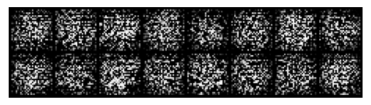

tensor([3, 9, 8, 4, 2, 7, 1, 1, 2, 0, 8, 7, 7, 5, 7, 6], device='cuda:0')


Epoch: 2/200:   0%|          | 0/7 [00:00<?, ?it/s]

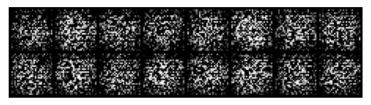

tensor([7, 6, 1, 8, 0, 9, 3, 9, 2, 0, 0, 4, 4, 5, 4, 3], device='cuda:0')


Epoch: 3/200:   0%|          | 0/7 [00:00<?, ?it/s]

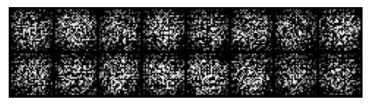

tensor([5, 1, 4, 3, 4, 8, 6, 1, 7, 4, 7, 0, 8, 7, 4, 3], device='cuda:0')


Epoch: 4/200:   0%|          | 0/7 [00:00<?, ?it/s]

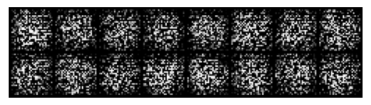

tensor([2, 1, 3, 6, 1, 4, 5, 1, 1, 7, 9, 0, 6, 5, 6, 8], device='cuda:0')


Epoch: 5/200:   0%|          | 0/7 [00:00<?, ?it/s]

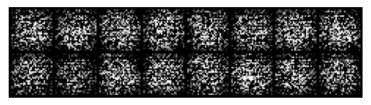

tensor([0, 1, 5, 5, 2, 4, 7, 1, 5, 0, 3, 9, 2, 2, 4, 1], device='cuda:0')


Epoch: 6/200:   0%|          | 0/7 [00:00<?, ?it/s]

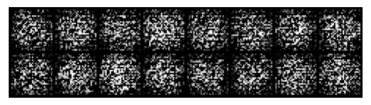

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

num_epochs=200

for epoch in tqdm(range(num_epochs)):
    p_bar=tqdm(dataloader, desc=f'Epoch: {epoch+1}/{num_epochs}: ')
    for batch in p_bar:
        real=batch[0].to(device)
        labels=batch[1].to(device)

        one_hot_label = F.one_hot(labels, n_classes)
        image_one_hot_label = repeat(one_hot_label,'b c -> b c h w', h=image_size[1], w=image_size[2])
        disc_opt.zero_grad()
        noise=torch.randn([batch_size, z_dim], device=device)
        nosie_and_label=torch.cat([noise, one_hot_label], dim=1)
        fake=gen(nosie_and_label).detach()

        fake_and_label=torch.cat([fake, image_one_hot_label], dim=1)
        real_and_label=torch.cat([real, image_one_hot_label], dim=1)
        fake_pred=disc(fake_and_label)
        real_pred=disc(real_and_label)

        fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred, device=device))
        real_loss = criterion(real_pred, torch.ones_like(real_pred, device=device))
        disc_loss = (fake_loss+real_loss)/2

        fake_acc = reduce(((fake_pred.squeeze()<0.5)==labels).float(), 'b -> ()', 'mean').float()
        real_acc = reduce(((real_pred.squeeze()>=0.5)==labels).float(), 'b -> ()', 'mean').float()
        disc_acc = (fake_acc+real_acc)/2

        disc_loss.backward()
        disc_opt.step()

        gen_opt.zero_grad()
        noise=torch.randn([batch_size, z_dim], device=device)
        nosie_and_label=torch.cat([noise, one_hot_label], dim=1)
        fake=gen(nosie_and_label).detach()
        fake_and_label=torch.cat([fake, image_one_hot_label], dim=1)
        pred=disc(real_and_label)
        gen_loss = criterion(pred, torch.ones_like(pred, device=device))
        gen_acc = reduce(((pred.squeeze()<0.5)==labels).float(), 'b -> ()', 'mean').float()

        gen_loss.backward()
        gen_opt.step()

        p_bar.set_postfix(gen_loss=gen_loss.item(), gen_acc=gen_acc.item(), disc_loss=disc_loss.item(), disc_acc=disc_acc.item())

    noise=torch.randn([batch_size,z_dim], device=device)
    labels=torch.randint(0,n_classes,[batch_size], device=device)
    one_hot_label = F.one_hot(labels, n_classes)
    noise_and_labels=torch.cat([noise, one_hot_label], dim=1)
    fake=gen(noise_and_labels)
    show_image(fake)
    print(labels[:16])


# Lightning

In [ ]:
from lightning.pytorch import Trainer, seed_everything
seed_everything(42, workers=True)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [ ]:
from torch.utils.data import random_split

class DataModule(L.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size=batch_size

        self.transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])

        self.shape= [1,28.28]
        self.num_classes=10

    def prepare_data(self):
        MNIST('.', train=True, download=True)
        MNIST('.', train=False, download=True)

    def setup(self, stage=None):
        if stage=='fit' or stage is None:
            dataset=MNIST('.', download=True, train=True, transform=self.transform)
            self.train, self.val = random_split(dataset, [55000, 5000])

        if stage=='test' or stage is None:
            self.test=MNIST('.', download=True, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False, drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=False, drop_last=True)


In [ ]:
class GAN(L.LightningModule):
    def __init__(self,z_dim, gen_hidden_dim, disc_hidden_dim, learning_rate, num_classes, batch_size, input_shape=[1,28,28]):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization=False

        self.gen=Generator(z_dim+num_classes, input_shape[0], gen_hidden_dim)
        self.disc=Discriminator(input_shape[0]+num_classes, disc_hidden_dim)

    def forward(self, x):
        return self.gen(x)

    def criterion(self,pred, y):
        return F.binary_cross_entropy_with_logits(pred, y)

    def training_step(self, batch):
        real=batch[0]
        labels=batch[1]

        gen_opt, disc_opt=self.optimizers()

        one_hot_label = F.one_hot(labels, self.hparams.num_classes)
        image_one_hot_label = repeat(one_hot_label,'b c -> b c h w', h=self.hparams.input_shape[1], w=self.hparams.input_shape[2])

        self.toggle_optimizer(disc_opt)
        noise=torch.randn([self.hparams.batch_size, self.hparams.z_dim], device=self.device)
        noise_and_label=torch.cat([noise, one_hot_label], dim=1)
        fake=self.gen(noise_and_label).detach()

        fake_and_label=torch.cat([fake, image_one_hot_label], dim=1)
        real_and_label=torch.cat([real, image_one_hot_label], dim=1)
        fake_pred=self.disc(fake_and_label)
        real_pred=self.disc(real_and_label)

        fake_loss = self.criterion(fake_pred, torch.zeros_like(fake_pred))
        real_loss = self.criterion(real_pred, torch.ones_like(real_pred))
        disc_loss = (fake_loss+real_loss)/2

        fake_acc = reduce(((torch.sigmoid(fake_pred.squeeze())<0.5)==labels).float(), 'b -> ()', 'mean').float()
        real_acc = reduce(((torch.sigmoid(real_pred.squeeze())>=0.5)==labels).float(), 'b -> ()', 'mean').float()
        disc_acc = (fake_acc+real_acc)/2

        self.manual_backward(disc_loss)
        disc_opt.step()
        self.untoggle_optimizer(disc_opt)


        self.toggle_optimizer(gen_opt)
        gen_opt.zero_grad()
        noise=torch.randn([self.hparams.batch_size, self.hparams.z_dim], device=self.device)
        noise_and_label=torch.cat([noise, one_hot_label], dim=1)
        fake=self.gen(noise_and_label)
        fake_and_label=torch.cat([fake, image_one_hot_label], dim=1)
        pred=self.disc(fake_and_label)
        gen_loss = self.criterion(pred, torch.ones_like(pred))
        gen_acc = reduce(((torch.sigmoid(pred.squeeze())<0.5)==labels).float(), 'b -> ()', 'mean').float()

        self.manual_backward(gen_loss)
        gen_opt.step()
        self.untoggle_optimizer(gen_opt)

        self.log("disc_loss", disc_loss.item(), prog_bar=True)
        self.log("disc_acc", disc_acc.item(), prog_bar=True)
        self.log("gen_loss", gen_loss.item(), prog_bar=True)
        self.log("gen_acc", gen_acc.item(), prog_bar=True)

    def configure_optimizers(self):
        gen_opt=torch.optim.Adam(self.gen.parameters(), lr=self.hparams.learning_rate)
        disc_opt=torch.optim.Adam(self.disc.parameters(), lr=self.hparams.learning_rate)

        return [gen_opt, disc_opt], []

    def on_train_epoch_end(self):
        noise=torch.randn([self.hparams.batch_size,self.hparams.z_dim], device=self.device)
        labels=torch.randint(0,self.hparams.num_classes, self.hparams.batch_size, device=self.device)
        one_hot_label = F.one_hot(labels, self.hparams.num_classes)
        noise_and_labels=torch.cat([noise, one_hot_label], dim=1)
        fake=gen(noise_and_labels)
        show_image(fake)
        print(labels[:16])

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

batch_size=4096
data_module=DataModule(batch_size)
model=GAN(z_dim=64, gen_hidden_dim=64, disc_hidden_dim=16, learning_rate=1e-3, num_classes=64,batch_size=batch_size,input_shape=[1,28,28])
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=5,
    deterministic=True
)
trainer.fit(model, data_module)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | gen  | Generator     | 895 K  | train
1 | disc | Discriminator | 25.5 K | train
-----------------------------------------------
920 K     Trainable params
0         Non-trainable params
920 K     Total params
3.683     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name | Type     

Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 338.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 71.06 MiB is free. Process 3140 has 14.68 GiB memory in use. Of the allocated memory 14.05 GiB is allocated by PyTorch, and 516.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)